# Exploring DeepDream with TensorFlow

**```This notebook demonstrates a number of Convolutional Neural Network image generation techniques implemented with TensorFlow for fun and science:```**

- **Visualize individual feature channels** — as well as their complex combinations — to systematically explore the representational space learned by deep convolutional neural networks such as **GoogLeNet** and **VGG16**.

- **Integrate TensorBoard graph visualizations** seamlessly within **Jupyter Notebooks** to facilitate interactive model inspection.

- **Employ tiled computation techniques** to generate high-resolution outputs efficiently.

- **Utilize Laplacian Pyramid Gradient Normalization** to create visually appealing, smooth, and vibrant representations with minimal computational overhead.

- **Synthesize DeepDream-inspired imagery** using TensorFlow — featuring surreal compositions such as the iconic _“DogSlugs”_.


## Visualizing Neural Representations with DeepDream

This notebook explores the inner workings of the **GoogLeNet architecture**, a deep convolutional neural network trained on the **ImageNet dataset** to classify images into 1,000 categories. GoogLeNet consists of multiple layers that apply a sequence of learned transformations to the input image. These transformation parameters were optimized through training using a variant of the **gradient descent algorithm**.

While the intermediate representations produced by the network may seem abstract or opaque, it is possible to **visualize and interpret** them in meaningful ways. In this notebook, we demonstrate a set of techniques designed to make these visualizations both **computationally efficient** and **visually compelling**.

> 📌 **Tip for the curious:**  
> If you're eager to see results right away, feel free to explore the **full galleries** of DeepDream images generated using these techniques—available for both **GoogLeNet** and **VGG16** architectures.

---

Through this process, we aim to make the hidden patterns learned by neural networks not only understandable—but also artistically fascinating.


#### _Boilerplate-Code_

In [3]:
from __future__ import print_function
import os
from io import BytesIO
import numpy as np
from functools import partial
import PIL.Image
from IPython.display import clear_output, Image, display, HTML

import tensorflow as tf

<a id='loading'></a>
## Loading and displaying the model graph

You can obtain the pretrained network by downloading it from the provided source. After downloading, extract the `tensorflow_inception_graph.pb` file from the archive and specify its path in the `model_fn` variable.

In [2]:
model_fn = 'tensorflow_inception_graph.pb'

# creating TensorFlow session and loading the model
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)
with tf.gfile.FastGFile(model_fn, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
t_input = tf.placeholder(np.float32, name='input') # define the input tensor
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)
tf.import_graph_def(graph_def, {'input':t_preprocessed})

## Exploring Learned Patterns in Convolutional Layers

To gain insight into the types of patterns the network has learned to recognize, we will generate images that **maximize the cumulative activation** of a specific feature channel within a chosen convolutional layer.

The network under examination consists of numerous convolutional layers, each producing **dozens to hundreds of feature channels**. These channels capture diverse visual patterns—ranging from simple edges to complex textures—providing a rich space for exploration and interpretation.


In [3]:
layers = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
feature_nums = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]

print('Number of layers', len(layers))
print('Total number of feature channels:', sum(feature_nums))


# Helper functions for TF Graph visualization

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = bytes("<stripped %d bytes>"%size, 'utf-8')
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def
  
def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

# Visualizing the network graph. Be sure expand the "mixed" nodes to see their 
# internal structure. We are going to visualize "Conv2D" nodes.
tmp_def = rename_nodes(graph_def, lambda s:"/".join(s.split('_',1)))
show_graph(tmp_def)

Number of layers 59
Total number of feature channels: 7548


<a id='naive'></a>
## Naive feature visualization

Let's start with a naive way of visualizing these. Image-space gradient ascent!

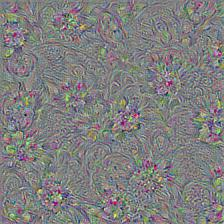

In [4]:
# Picking some internal layer. Note that we use outputs before applying the ReLU nonlinearity
# to have non-zero gradients for features with negative initial activations.
layer = 'mixed4d_3x3_bottleneck_pre_relu'
channel = 139 # picking some feature channel to visualize

# start with a gray image with a little noise
img_noise = np.random.uniform(size=(224,224,3)) + 100.0

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 1)*255)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
    
def visstd(a, s=0.1):
    '''Normalize the image range for visualization'''
    return (a-a.mean())/max(a.std(), 1e-4)*s + 0.5

def T(layer):
    '''Helper for getting layer output tensor'''
    return graph.get_tensor_by_name("import/%s:0"%layer)

def render_naive(t_obj, img0=img_noise, iter_n=20, step=1.0):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    
    img = img0.copy()
    for i in range(iter_n):
        g, score = sess.run([t_grad, t_score], {t_input:img})
        # normalizing the gradient, so the same step size should work 
        g /= g.std()+1e-8         # for different layers and networks
        img += g*step
        print(score, end = ' ')
    clear_output()
    showarray(visstd(img))

render_naive(T(layer)[:,:,:,channel])

### Multiscale Image Generation

The network appears to be revealing some fascinating patterns—let's help bring them into focus. We'll use **gradient ascent across multiple scales** to enhance and evolve these patterns. In this process, details formed at smaller scales are progressively upscaled and enriched at higher resolutions.

While it might be tempting to use a high number of octaves to generate large, high-resolution images (like wallpapers), doing so can quickly exceed available GPU memory. This happens because storing network activations and backpropagation values becomes increasingly expensive.

A simple and effective strategy to avoid this issue is to **split the image into smaller tiles** and compute the gradients for each tile independently. Additionally, applying **random shifts** to the image before each iteration helps eliminate tile seams and significantly improves overall image quality.


In [5]:
def tffunc(*argtypes):
    '''Helper that transforms TF-graph generating function into a regular one.
    See "resize" function below.
    '''
    placeholders = list(map(tf.placeholder, argtypes))
    def wrap(f):
        out = f(*placeholders)
        def wrapper(*args, **kw):
            return out.eval(dict(zip(placeholders, args)), session=kw.get('session'))
        return wrapper
    return wrap

# Helper function that uses TF to resize an image
def resize(img, size):
    img = tf.expand_dims(img, 0)
    return tf.image.resize_bilinear(img, size)[0,:,:,:]
resize = tffunc(np.float32, np.int32)(resize)


def calc_grad_tiled(img, t_grad, tile_size=512):
    '''Compute the value of tensor t_grad over the image in a tiled way.
    Random shifts are applied to the image to blur tile boundaries over 
    multiple iterations.'''
    sz = tile_size
    h, w = img.shape[:2]
    sx, sy = np.random.randint(sz, size=2)
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    grad = np.zeros_like(img)
    for y in range(0, max(h-sz//2, sz),sz):
        for x in range(0, max(w-sz//2, sz),sz):
            sub = img_shift[y:y+sz,x:x+sz]
            g = sess.run(t_grad, {t_input:sub})
            grad[y:y+sz,x:x+sz] = g
    return np.roll(np.roll(grad, -sx, 1), -sy, 0)

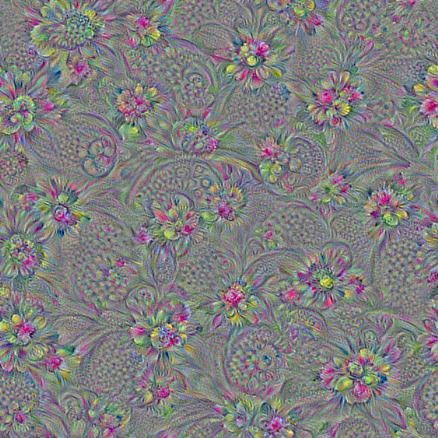

In [6]:
def render_multiscale(t_obj, img0=img_noise, iter_n=10, step=1.0, octave_n=3, octave_scale=1.4):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    
    img = img0.copy()
    for octave in range(octave_n):
        if octave>0:
            hw = np.float32(img.shape[:2])*octave_scale
            img = resize(img, np.int32(hw))
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            # normalizing the gradient, so the same step size should work 
            g /= g.std()+1e-8         # for different layers and networks
            img += g*step
            print('.', end = ' ')
        clear_output()
        showarray(visstd(img))

render_multiscale(T(layer)[:,:,:,channel])

<a id="laplacian"></a>

## Laplacian Pyramid Gradient Normalization

The current results demonstrate noticeable improvement; however, the generated images predominantly emphasize high-frequency components. This raises the question: can the outcome be further refined?

One effective strategy involves incorporating a smoothness prior into the optimization objective. By introducing a controlled blurring step at each iteration, this approach attenuates high-frequency artifacts, allowing lower-frequency structures to emerge more clearly. While this method enhances perceptual coherence, it generally necessitates a greater number of iterations to yield visually compelling results.

An alternative approach is to directly amplify the contribution of low-frequency gradients. This can be accomplished using a [Laplacian pyramid](https://en.wikipedia.org/wiki/Pyramid_%28image_processing%29#Laplacian_pyramid) decomposition, which enables multi-scale processing of the gradient information. The resulting method is known as _Laplacian Pyramid Gradient Normalization_, and it offers a principled way to balance frequency components during optimization.


In [7]:
k = np.float32([1,4,6,4,1])
k = np.outer(k, k)
k5x5 = k[:,:,None,None]/k.sum()*np.eye(3, dtype=np.float32)

def lap_split(img):
    '''Split the image into lo and hi frequency components'''
    with tf.name_scope('split'):
        lo = tf.nn.conv2d(img, k5x5, [1,2,2,1], 'SAME')
        lo2 = tf.nn.conv2d_transpose(lo, k5x5*4, tf.shape(img), [1,2,2,1])
        hi = img-lo2
    return lo, hi

def lap_split_n(img, n):
    '''Build Laplacian pyramid with n splits'''
    levels = []
    for i in range(n):
        img, hi = lap_split(img)
        levels.append(hi)
    levels.append(img)
    return levels[::-1]

def lap_merge(levels):
    '''Merge Laplacian pyramid'''
    img = levels[0]
    for hi in levels[1:]:
        with tf.name_scope('merge'):
            img = tf.nn.conv2d_transpose(img, k5x5*4, tf.shape(hi), [1,2,2,1]) + hi
    return img

def normalize_std(img, eps=1e-10):
    '''Normalize image by making its standard deviation = 1.0'''
    with tf.name_scope('normalize'):
        std = tf.sqrt(tf.reduce_mean(tf.square(img)))
        return img/tf.maximum(std, eps)

def lap_normalize(img, scale_n=4):
    '''Perform the Laplacian pyramid normalization.'''
    img = tf.expand_dims(img,0)
    tlevels = lap_split_n(img, scale_n)
    tlevels = list(map(normalize_std, tlevels))
    out = lap_merge(tlevels)
    return out[0,:,:,:]

# Showing the lap_normalize graph with TensorBoard
lap_graph = tf.Graph()
with lap_graph.as_default():
    lap_in = tf.placeholder(np.float32, name='lap_in')
    lap_out = lap_normalize(lap_in)
show_graph(lap_graph)

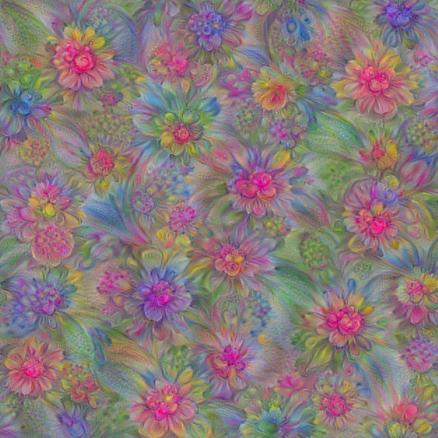

In [8]:
def render_lapnorm(t_obj, img0=img_noise, visfunc=visstd,
                   iter_n=10, step=1.0, octave_n=3, octave_scale=1.4, lap_n=4):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    # build the laplacian normalization graph
    lap_norm_func = tffunc(np.float32)(partial(lap_normalize, scale_n=lap_n))

    img = img0.copy()
    for octave in range(octave_n):
        if octave>0:
            hw = np.float32(img.shape[:2])*octave_scale
            img = resize(img, np.int32(hw))
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            g = lap_norm_func(g)
            img += g*step
            print('.', end = ' ')
        clear_output()
        showarray(visfunc(img))

render_lapnorm(T(layer)[:,:,:,channel])

<a id="playing"></a>

## Exploring Feature Visualizations

With just 10 iterations per octave, we were able to generate a remarkably smooth image. When executed on a GPU, this process completes in mere seconds.

To further explore the network's representational capacity, let us visualize a different channel within the same layer. The model is capable of producing a rich and diverse array of patterns, reflecting the complexity of learned features across various spatial and semantic scales.


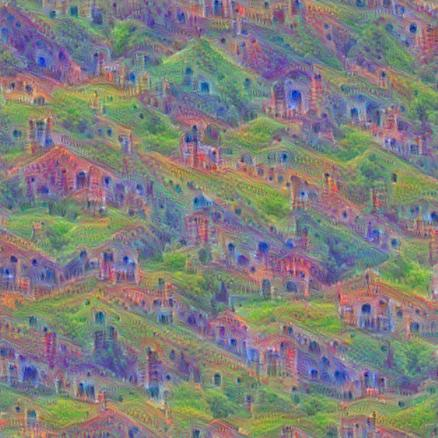

In [9]:
render_lapnorm(T(layer)[:,:,:,65])

Lower layers produce features of lower complexity.

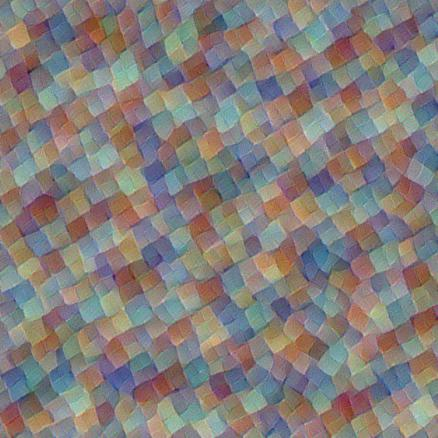

In [10]:
render_lapnorm(T('mixed3b_1x1_pre_relu')[:,:,:,101])

There are many interesting things one may try. For example, optimizaing a linear combination of features often gives a "mixture" pattern.

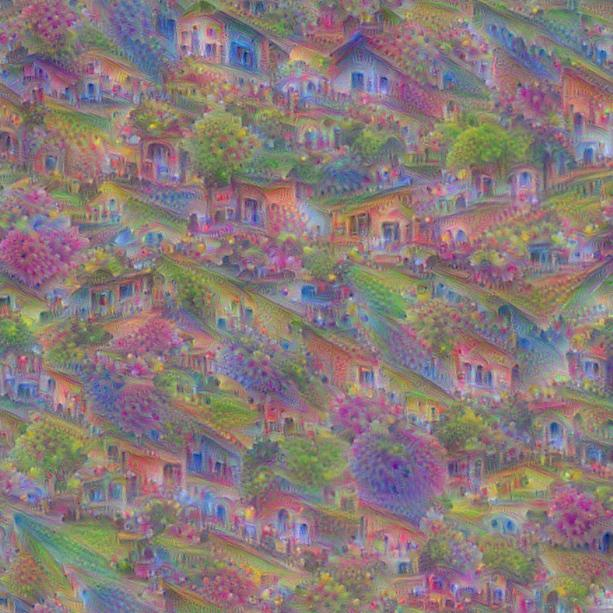

In [11]:
render_lapnorm(T(layer)[:,:,:,65]+T(layer)[:,:,:,139], octave_n=4)

<a id="deepdream"></a>
## DeepDream

Now let's reproduce with TensorFlow. 


In [12]:
def render_deepdream(t_obj, img0=img_noise,
                     iter_n=10, step=1.5, octave_n=4, octave_scale=1.4):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!

    # split the image into a number of octaves
    img = img0
    octaves = []
    for i in range(octave_n-1):
        hw = img.shape[:2]
        lo = resize(img, np.int32(np.float32(hw)/octave_scale))
        hi = img-resize(lo, hw)
        img = lo
        octaves.append(hi)
    
    # generate details octave by octave
    for octave in range(octave_n):
        if octave>0:
            hi = octaves[-octave]
            img = resize(img, hi.shape[:2])+hi
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            img += g*(step / (np.abs(g).mean()+1e-7))
            print('.',end = ' ')
        clear_output()
        showarray(img/255.0)

Let's load some image and populate it with DogSlugs (in case you've missed them).

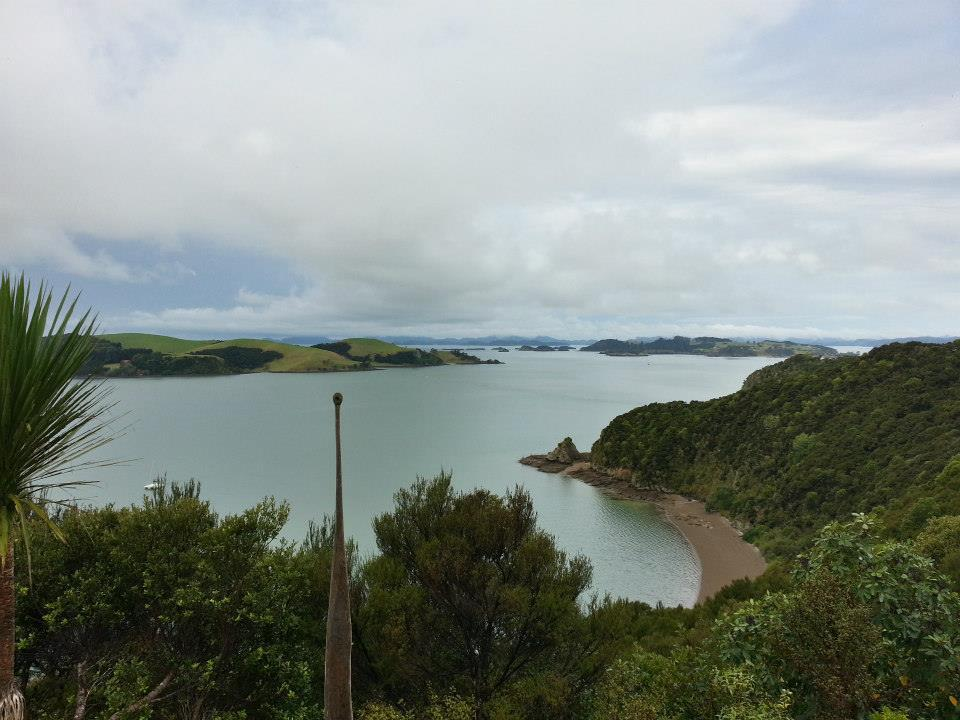

In [13]:
img0 = PIL.Image.open('images.jpg')
img0 = np.float32(img0)
showarray(img0/255.0)

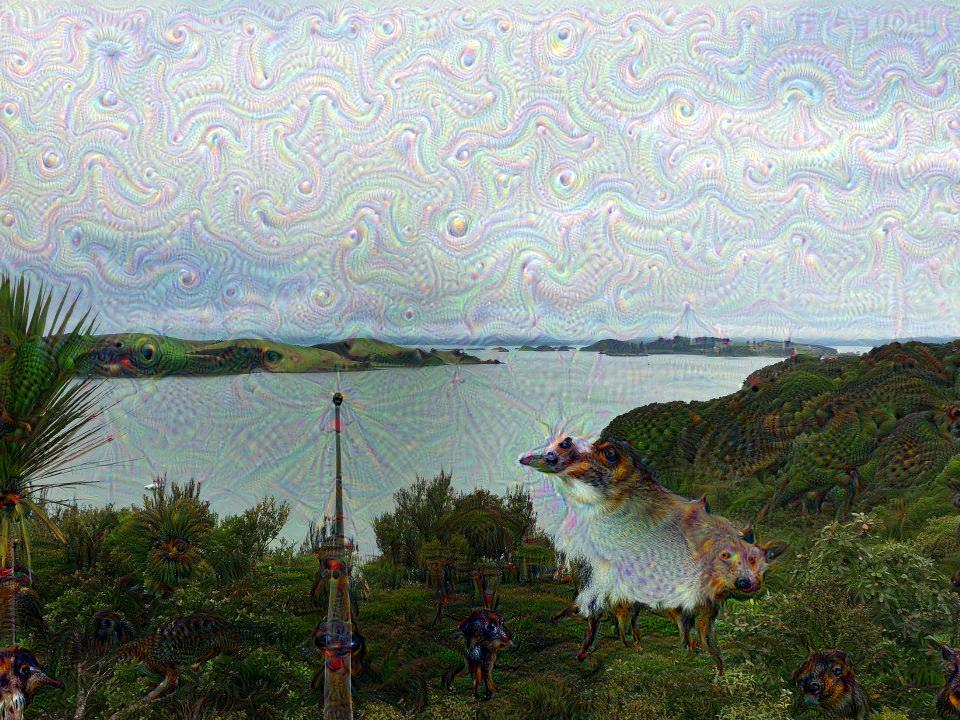

In [14]:
render_deepdream(tf.square(T('mixed4c')), img0)

Note that results can differ from the [Caffe](https://github.com/BVLC/caffe)'s implementation, as we are using an independently trained network. Still, the network seems to like dogs and animal-like features due to the nature of the ImageNet dataset.

Using an arbitrary optimization objective still works:

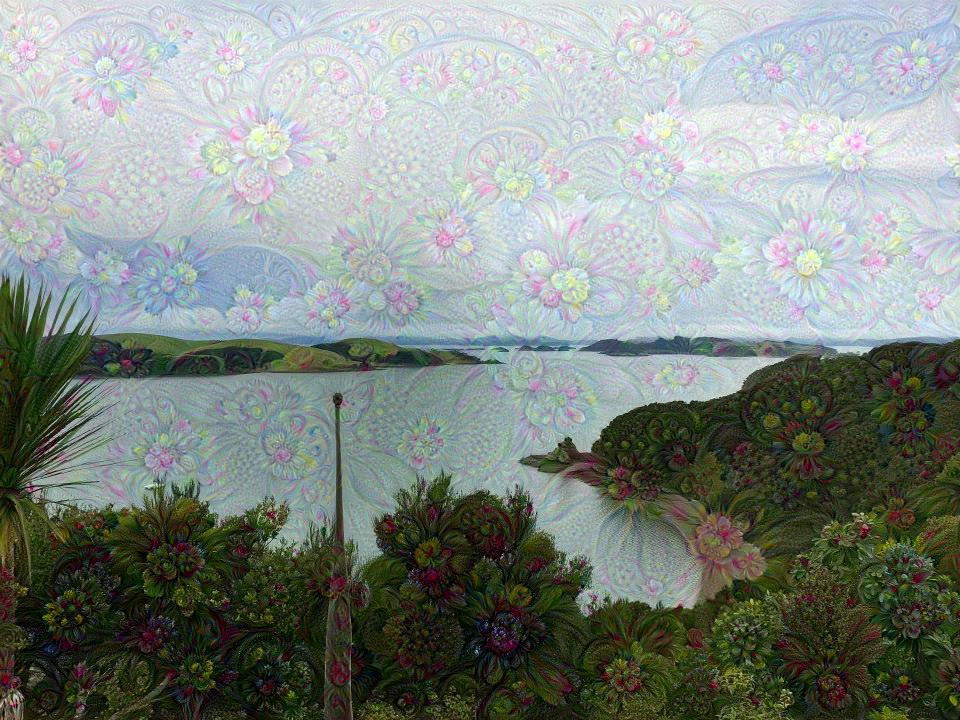

In [15]:
render_deepdream(T(layer)[:,:,:,139], img0)

Don't hesitate to use higher resolution inputs (also increase the number of octaves)! Here is an [example](http://storage.googleapis.com/deepdream/pilatus_flowers.jpg) of running the flower dream over the bigger image.

We hope that the visualization tricks described here may be helpful for analyzing representations learned by neural networks or find their use in various artistic applications.

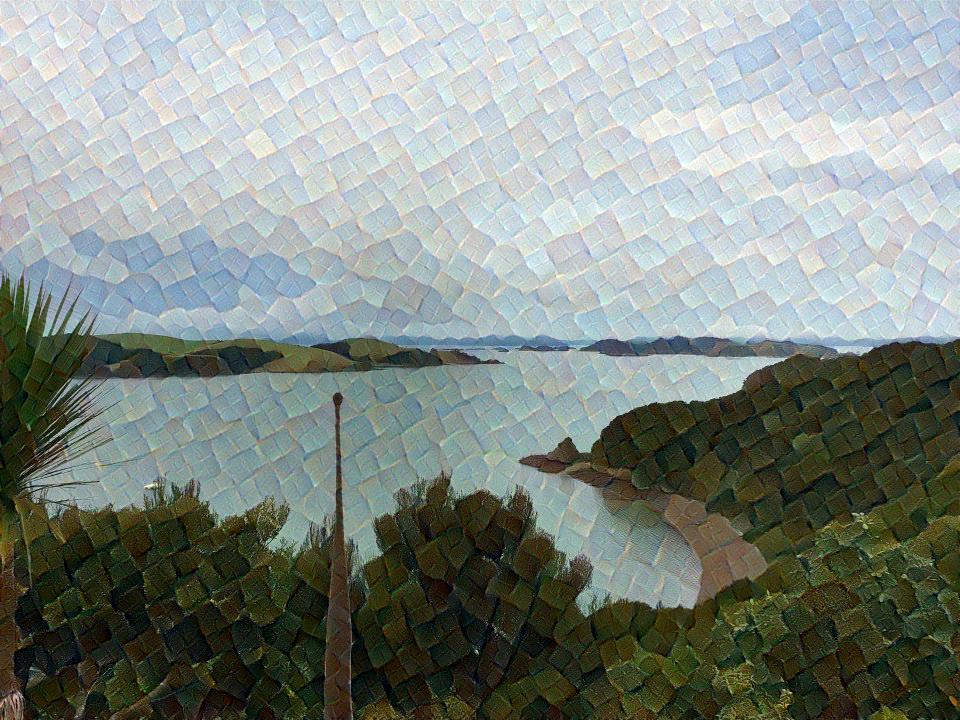

In [16]:
render_deepdream(T('mixed3b_1x1_pre_relu')[:,:,:,101], img0)

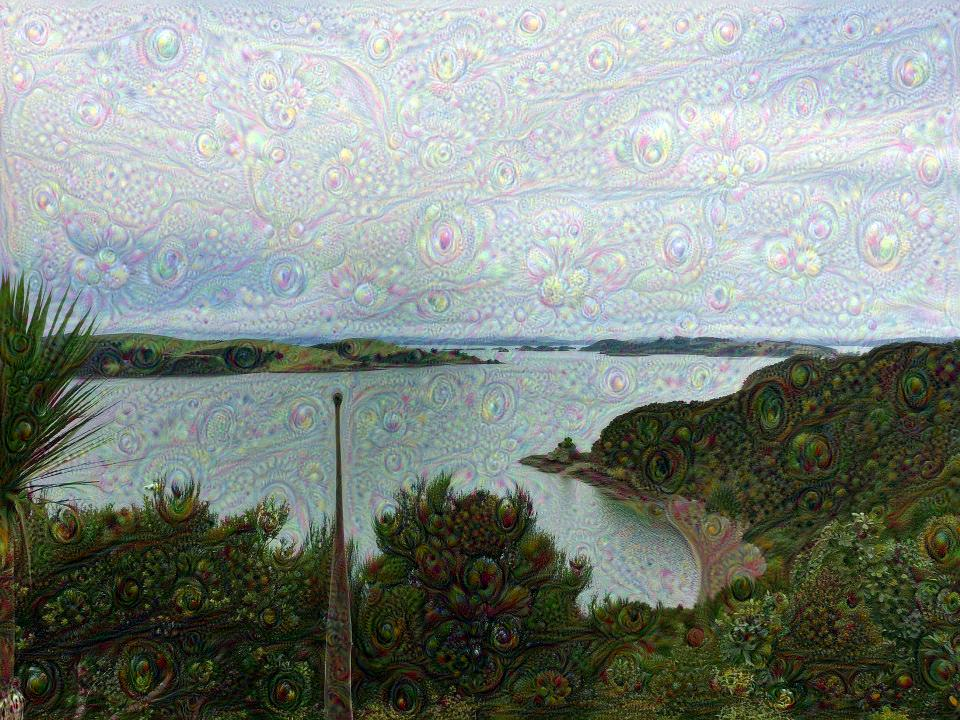

In [20]:
render_deepdream(T(layer)[:,:,:,20] + T(layer)[:,:,:,139], img0)

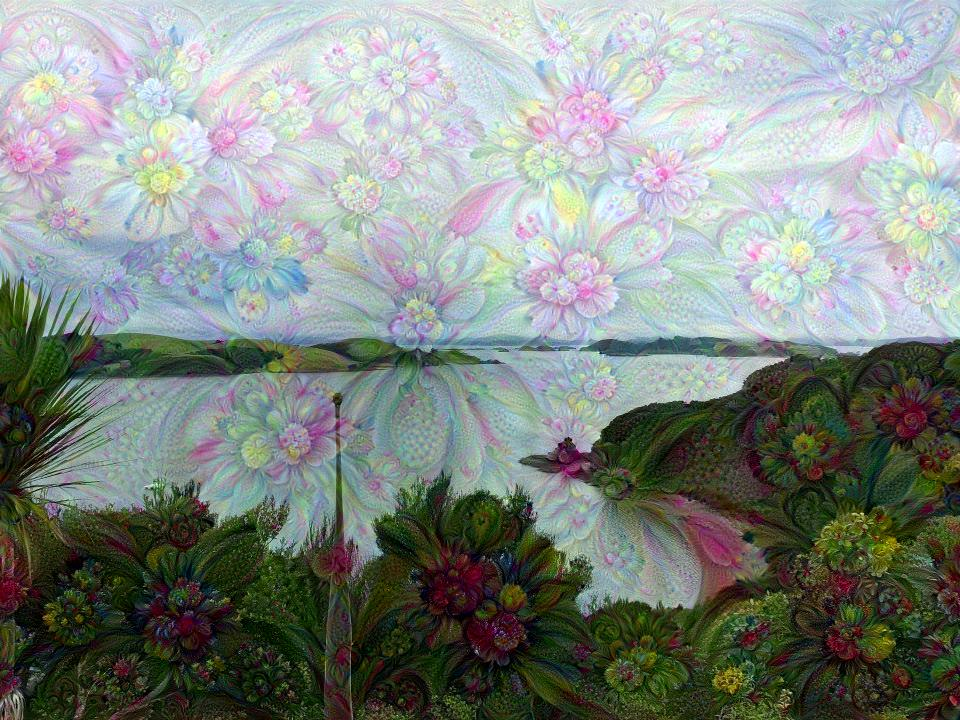

In [21]:
render_deepdream(T(layer)[:,:,:,139], img0, octave_n=8)

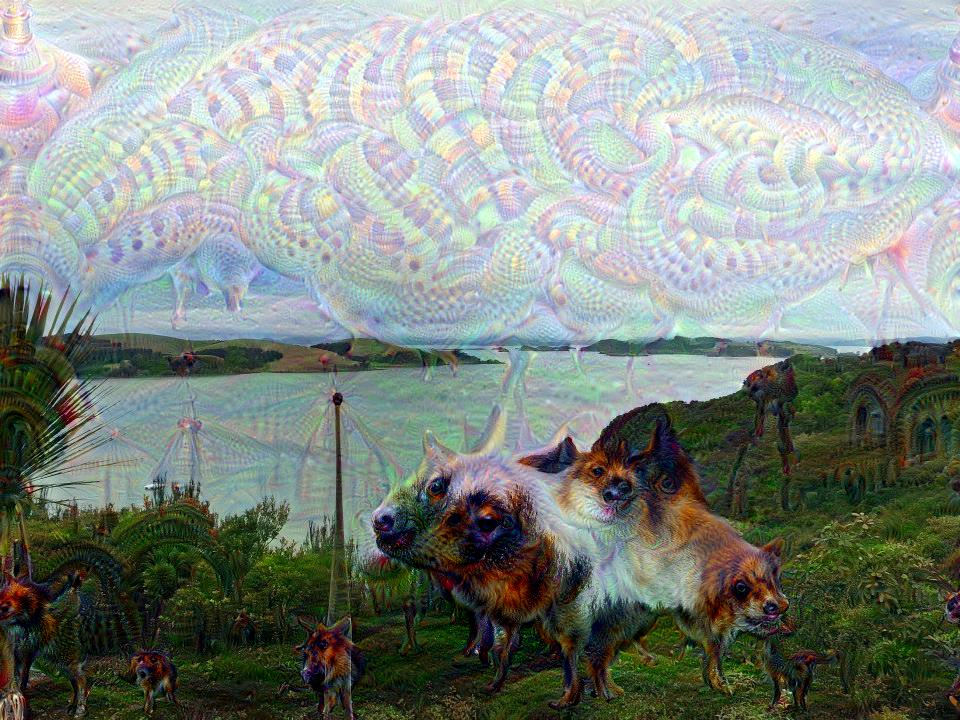

In [23]:
render_deepdream(tf.square(T('mixed4c')), img0, octave_n=8)

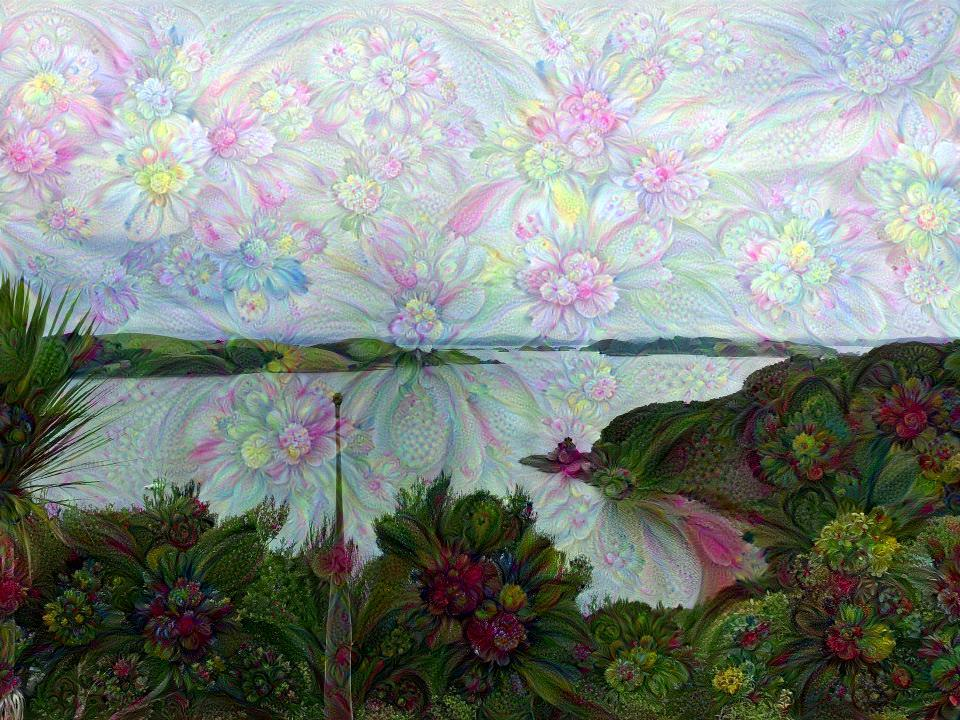

In [27]:
img1 = PIL.Image.open('view-extra flowery.jpg')
img1 = np.float32(img1)
showarray(img1/255.0)

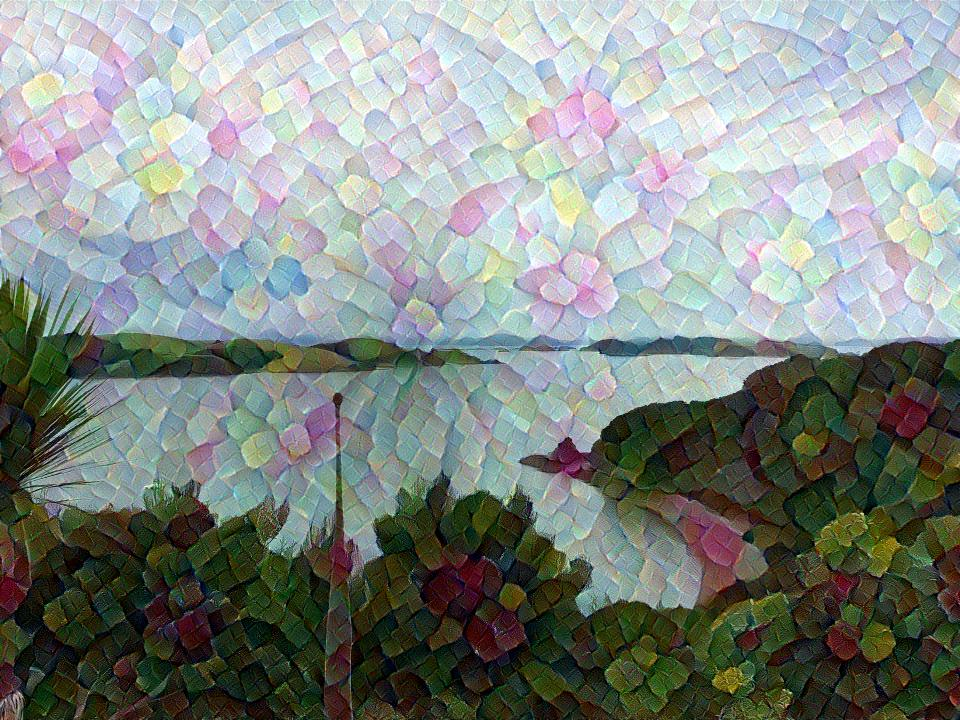

In [29]:
render_deepdream(T('mixed3b_1x1_pre_relu')[:,:,:,101], img1)

## Conclusion

This notebook has presented a detailed investigation into the interpretability and expressive capacity of convolutional neural networks (CNNs) through the DeepDream framework, implemented using TensorFlow. By synthesizing and visualizing internal activations across layers and channels, we gained valuable qualitative insights into the hierarchical representations learned by deep models such as GoogLeNet and VGG16.

### Key Insights and Techniques

We began by visualizing individual feature channels and their combinations to uncover the emergent structure within CNNs. These visualizations exposed how early layers capture low-level patterns such as edges and textures, while deeper layers become sensitive to increasingly complex, abstract features.

To enhance image quality and interpretability, we incorporated **Laplacian Pyramid Gradient Normalization**, a frequency-aware regularization technique. This method balanced the contribution of low- and high-frequency gradients, allowing for the generation of smoother, more visually coherent images. Unlike naive gradient ascent, this approach reduces the dominance of noisy high-frequency artifacts and reveals a more structured activation landscape.

We also explored **tiled computation**, which enabled us to generate high-resolution images efficiently without overwhelming memory resources. This method stitches smaller patches of optimized regions together, effectively supporting large-scale feature visualizations across different zoom levels and spatial contexts.

### Visualization as Interpretation

By iteratively modifying input images to maximize activations of specific neurons or layers, we reverse-engineered the network’s perception — visualizing what the model has learned to recognize. The results include a wide variety of artistic, often surreal outputs, which not only intrigue visually but serve as windows into how information flows and accumulates within the network.

Such techniques serve dual purposes:
1. **Scientific Understanding** – helping researchers and engineers demystify what deep models "see" internally.
2. **Creative Expression** – enabling artists and developers to use neural models as generative engines for novel imagery.

### Broader Implications

This experiment affirms the utility of DeepDream and similar tools in the broader field of explainable AI (XAI). Feature visualization can complement quantitative interpretability metrics by offering intuitive, human-accessible representations of model behavior. Furthermore, it highlights the importance of designing optimization objectives and regularization strategies thoughtfully, especially when working with generative or interpretive models.

### Final Thoughts

In conclusion, the techniques demonstrated in this notebook underscore the power of deep learning not only as a predictive framework but also as a medium of exploration and creativity. DeepDream exemplifies a class of tools that transform opaque neural models into interactive visual systems, promoting transparency, understanding, and inspiration across disciplines. As neural networks continue to evolve in scale and complexity, such visualization frameworks will remain integral to both scientific inquiry and artistic innovation.
